In [44]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from keras.utils.np_utils import to_categorical  

from torchsummary import summary

from torch.optim import lr_scheduler

from sklearn.preprocessing import StandardScaler

import time
import copy
import pickle
from joblib import dump
import json

In [2]:
# Enable gpu support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!gdown --id 1sc2qFcOeJp2hYAj50i8Xj9VwW6qfePAl

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sc2qFcOeJp2hYAj50i8Xj9VwW6qfePAl
To: /content/train.csv
100% 241M/241M [00:02<00:00, 95.8MB/s]


# Data extraction and preprocessing

In [5]:
data = pd.read_csv('train.csv')


In [6]:
display(data.head())
data.shape

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


(28709, 2)

In [7]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [8]:
X = np.array([
              [i for i in map(int, row)] for row 
              in map(str.split, data['pixels'].values)
      ]).reshape((-1, 48, 48))

In [9]:
X.dtype

dtype('int64')

In [10]:
X.shape

(28709, 48, 48)

In [11]:
y = data['emotion']
display(y.value_counts())
y = y.values

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

# Dataset

In [36]:
X.mean(), X.var()

(129.47433955331468, 4228.546296819005)

In [12]:
#     tempT = transforms.Compose([
#             transforms.Lambda(lambda x: x.unsqueeze(1)),            
#             transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1))                
# ])    

In [52]:
class EmotionsDataset(Dataset):
  def __init__(self, X, y, transform=None, to_rgb=True, 
               standardization_mode=True):
    self.transform = transform
    self.standardization_mode = standardization_mode
    self.standardization_filename = 'mean_var.json'

    self.y = y

    self.X_tensor, self.y_tensor = self._transform(X, y, to_rgb)
  
  def __len__(self):
    return len(self.y_tensor)
  
  def __getitem__(self, index):
    X, y = self.X_tensor[index], self.y_tensor[index]

    if self.transform:
      X = self.transform(X)

    return X, y
  
  def _transform(self, X, y, to_rgb):
    X = torch.from_numpy(X).float().to(device)
    X = self._standardize(X).unsqueeze(1)

    y = torch.from_numpy(to_categorical(y, num_classes=7)).float().to(device)

    if to_rgb:
      X = X.repeat(1, 3, 1, 1)

    return X, y
  
  def _standardize(self, X):
    if self.standardization_mode == 'fit_transform':
      mean, var = X.mean(), X.var()

      with open(self.standardization_filename, 'w', encoding ='utf8') as file:
        json.dump({
            'mean': float(mean),
            'var': float(var)
        }, file)

    elif self.standardization_mode == 'transform':
      with open(self.standardization_filename, 'r', encoding ='utf8') as file:
        data = json.load(file)
      
      mean, var = data['mean'], data['var']
    
    else:
      raise TypeError(
          'Unkown option "standardization_mode"\n'
          'Choose from: fit_transform, transform\n'
      )
    
    return transforms.Normalize(mean, var)(X)


# Augmentation

In [14]:
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomPerspective(distortion_scale=0.35)
    ])

# Data visualisation

In [15]:
target_names = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

In [16]:
def plot_images(X, y, transform=None, classes=7, columns=5):
  _X = np.zeros((classes * columns, 48, 48))
  _y = []
  
  X, y = copy.deepcopy(X), copy.deepcopy(y)

  if transform:
    data_loader = DataLoader(EmotionsDataset(X, y, transform, to_rgb=False),
                             batch_size=2048)

    X, y = next(iter(data_loader))

    X = X.squeeze(1).cpu()
    y = np.argmax(y.cpu(), axis=1)


  for label in range(classes):
    mask = (y == label)
    _X[columns * label : columns * label + columns] = X[mask, :][:columns]
    _y.extend([label] * columns)

  _, axes = plt.subplots(nrows=classes, ncols=columns, figsize=(15, 15))
  for ax, image, label in zip(axes.flatten(), _X, _y):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(image, cmap=plt.cm.gist_gray)
      ax.set_title(target_names[label])

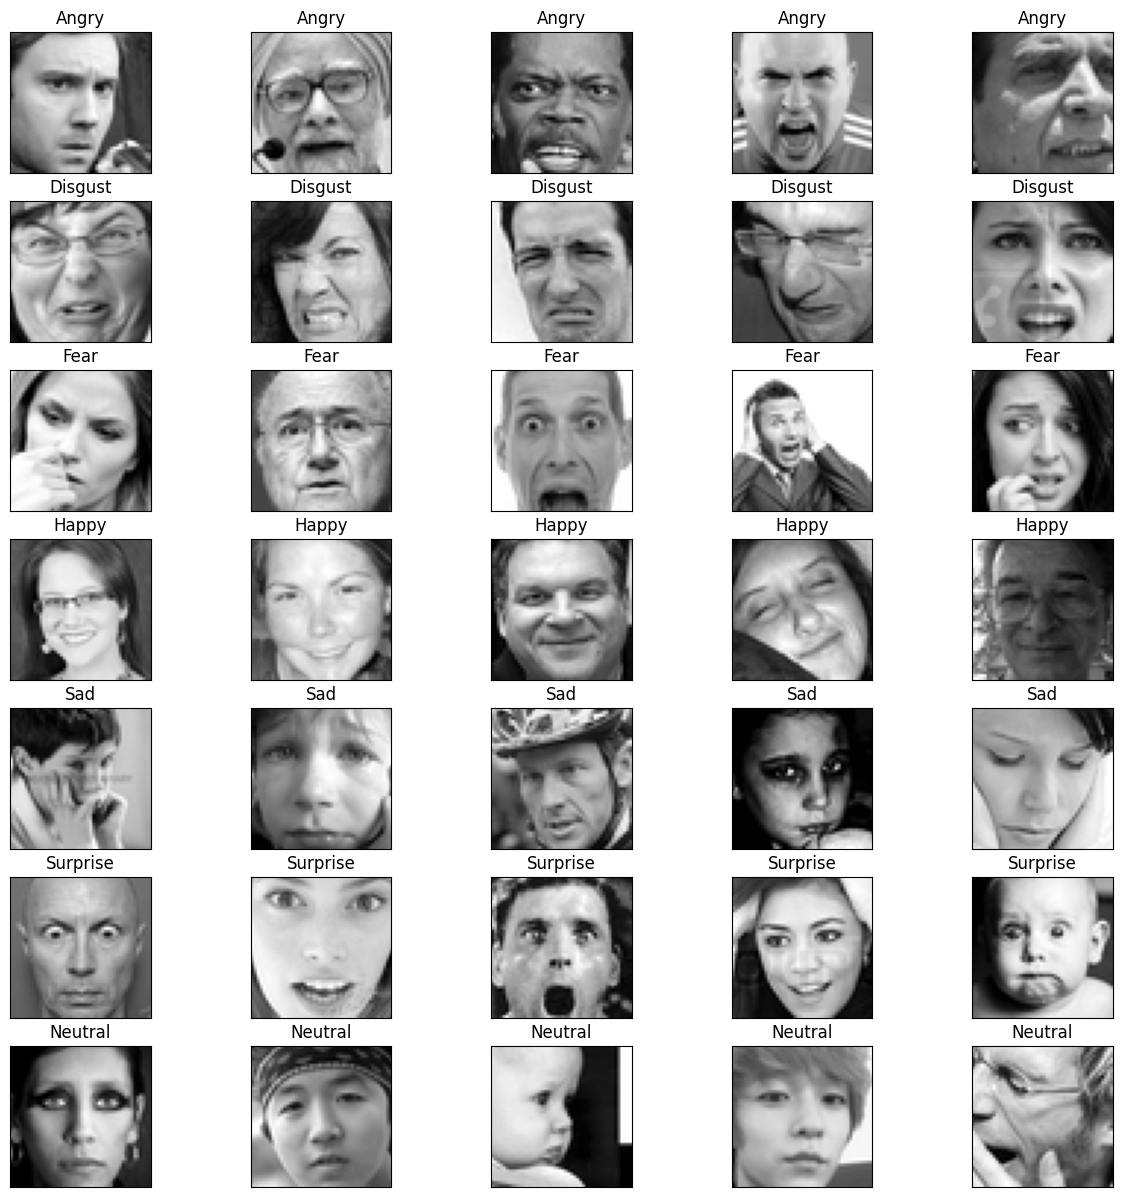

In [17]:
plot_images(X, y)

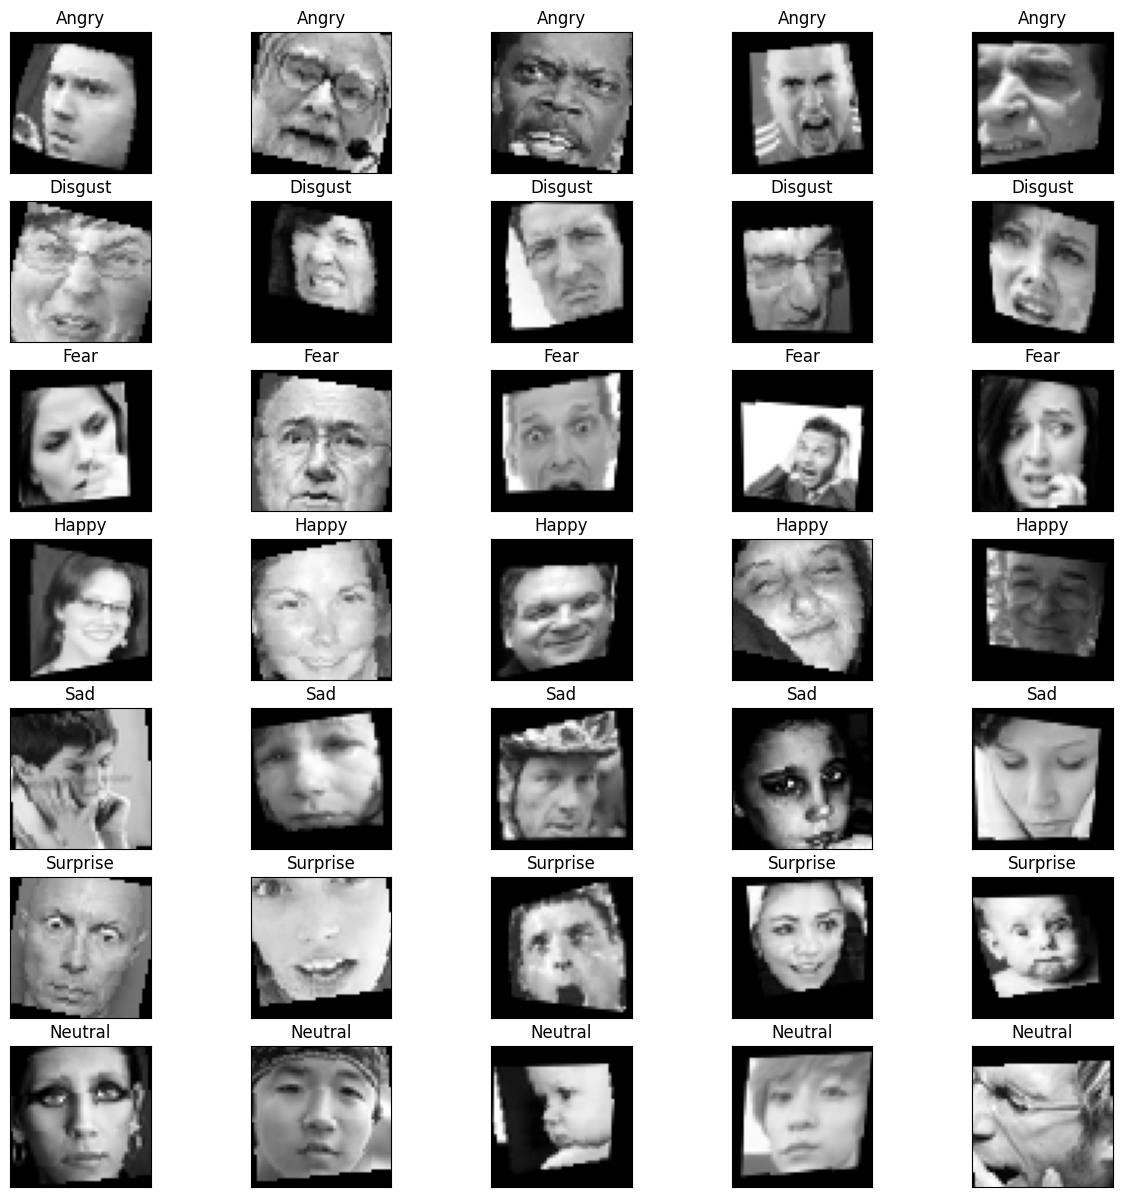

In [18]:
plot_images(X, y, transform)

# Augmentation expirements

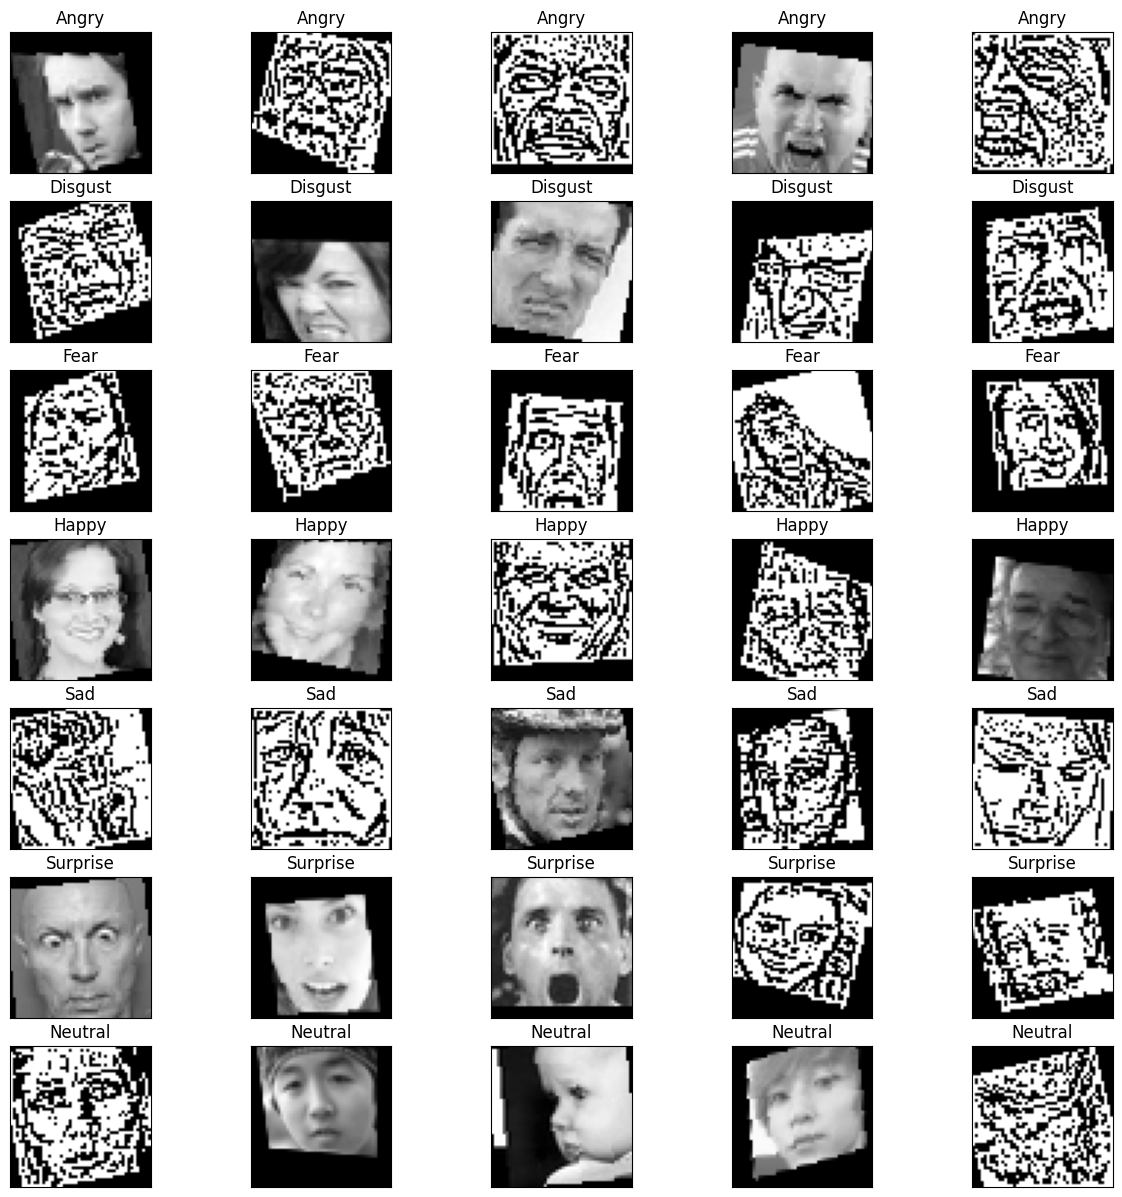

In [19]:
_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomPerspective(distortion_scale=0.35),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomAdjustSharpness(sharpness_factor=150)
    ])

plot_images(X, y, _transform)

# Plots

In [20]:
def plot_confusin_matrix(y_real, y_test):
  confusion_matrix = metrics.confusion_matrix(y_real, y_test)
  sns.heatmap(confusion_matrix, center=0, cmap='PiYG', annot=True)

  plt.show()

In [21]:
def plot_loss(train_loss, test_loss, ylim=False):
  x = [i for i in range(1, len(train_loss) + 1)]

  plt.plot(x, train_loss, label='train')
  plt.plot(x, test_loss, label='test')

  if ylim:
    plt.ylim(0, 10)

  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [22]:
def plot_accuracy(train_accuracies, test_accuracies, step):
  x = [i for i in range(1, step * len(train_accuracies) + 1, step)]

  plt.plot(x, train_accuracies, label='train')
  plt.plot(x, test_accuracies, label='validation')

  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

# Models

In [23]:
class Net(nn.Module):
  def __init__(self, backbone):
    super(Net, self).__init__()
    
    # last layer
    backbone.fc = nn.Linear(backbone.fc.in_features, 7, bias=True)

    self.model = nn.Sequential(
        backbone
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

In [24]:
# Testing model
def test_model(model, test_loader, criterion=None, return_predictions=False):
    predictions = []
    labels = []
    loss_sum = 0.

    model.eval()
    
    for images, y in test_loader: 
      with torch.no_grad(): 
        outputs = model(images)

        if criterion:
          loss_sum += criterion(outputs, y)

        predictions += torch.argmax(outputs.data, axis=1).cpu()
        labels += torch.argmax(y.data, axis=1).cpu()
    
    model.train()
    
    d = {}

    d['accuracy'] = metrics.accuracy_score(labels, predictions)

    if return_predictions:
      d['predictions'] = predictions
    
    if criterion:
      d['loss'] = (loss_sum / len(test_loader)).cpu()
    
    return d

In [25]:
# Training model
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader,
                epochs, test_step):
    print('\n* Model training * ')

    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []
    
    model.train()

    for epoch in range(epochs):
        print(f'* Epoch #{epoch + 1}')
        for batch, (images, labels) in enumerate(train_loader):
          
          optimizer.zero_grad()
          
          # forward
          outputs = model(images)
          loss = criterion(outputs, labels)

          # backward
          loss.backward()
          # torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
          
          optimizer.step()
          # scheduler.step()

        # validation
        if epoch % test_step == 0:
          train_dict = test_model(model, train_loader, criterion=criterion)
          train_accuracies.append(train_dict['accuracy'])
          train_losses.append(train_dict['loss'])

          test_dict = test_model(model, test_loader, criterion=criterion)
          test_accuracies.append(test_dict['accuracy'])
          test_losses.append(test_dict['loss'])

          
          print('\tTrain accuracy', train_dict['accuracy'])
          print('\tTest accuracy', test_dict['accuracy'])
          print()
          print('\tTrain loss', train_dict['loss'])
          print('\tTest loss', test_dict['loss'])
          print()

    return {
        'train_accuracies': train_accuracies, 
        'test_accuracies': test_accuracies, 
        'train_losses': train_losses,
        'test_losses': test_losses
        }

In [61]:
def run_pipeline(
    X,
    y,
    model=models.resnet18(pretrained=True), 
    batch_size=2048,
    lr=5e-4,
    epochs=1,
    transform=None,
    test_step=1,
    weight_decay=0.01,
    max_lr=1e-3,
    show_summary=False,
    random_state=42):

    # Reproducibility
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
  
    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=random_state
    )

    # Datasets
    train = EmotionsDataset(X_train, y_train, transform,
                            standardization_mode='fit_transform')
    val = EmotionsDataset(X_val, y_val, standardization_mode='transform')
    test = EmotionsDataset(X_test, y_test, standardization_mode='transform')

    # Sampler
    counts = np.unique(y_train, return_counts=True)[1]
    class_weights = np.power(counts, -1, dtype=float)

    sample_weights = [class_weights[label] for i, label in enumerate(y_train)]

    sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=len(sample_weights),
                                replacement=True)

    # DataLoaders
    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              sampler=sampler,
                              drop_last=True)
    val_loader = DataLoader(val,
                            batch_size=batch_size,
                            shuffle=False)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             shuffle=False)

    # Model
    net = Net(backbone=model).float().to(device)
    
    # Model summary
    if show_summary:
        summary(net, (1, 48, 48))

    # Loss
    error=nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)

    # LR scheduler
    # scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                     steps_per_epoch=len(train_loader),
    #                                     pct_start = 0.4, 
    #                                     three_phase=False, verbose=True)
    scheduler = None

    # Training
    train_results = train_model(net, error, optimizer, scheduler, 
                                train_loader, val_loader, epochs, test_step)
    # Testing
    test_results = test_model(net, test_loader, return_predictions=True)
    print('Accuracy: ', test_results['accuracy'])

    # Plots
    plot_confusin_matrix(y_test, test_results['predictions'])
    plot_loss(train_results['train_losses'], train_results['test_losses'])
    plot_loss(train_results['train_losses'], train_results['test_losses'], ylim=True)
    plot_accuracy(train_results['train_accuracies'], train_results['test_accuracies'],
                  test_step)
    
    # Save model
    torch.save(net.state_dict(), 'model.pth')

    return net

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



* Model training * 
* Epoch #1
	Train accuracy 0.16712535511363635
	Test accuracy 0.27063740856844304

	Train loss tensor(3.0146)
	Test loss tensor(2.4917)

* Epoch #2
	Train accuracy 0.23548473011363635
	Test accuracy 0.32497387669801464

	Train loss tensor(2.7849)
	Test loss tensor(1.8971)

* Epoch #3
	Train accuracy 0.5492720170454546
	Test accuracy 0.5228143504005573

	Train loss tensor(1.3033)
	Test loss tensor(1.2489)

* Epoch #4
	Train accuracy 0.6783558238636364
	Test accuracy 0.5454545454545454

	Train loss tensor(0.8607)
	Test loss tensor(1.2124)

* Epoch #5
	Train accuracy 0.6986416903409091
	Test accuracy 0.5607802159526297

	Train loss tensor(0.8142)
	Test loss tensor(1.2649)

Accuracy:  0.5600835945663531


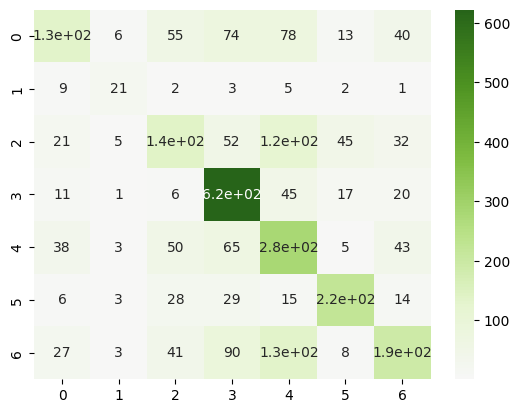

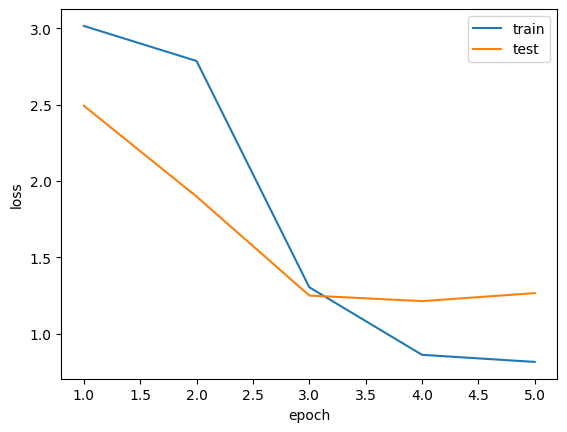

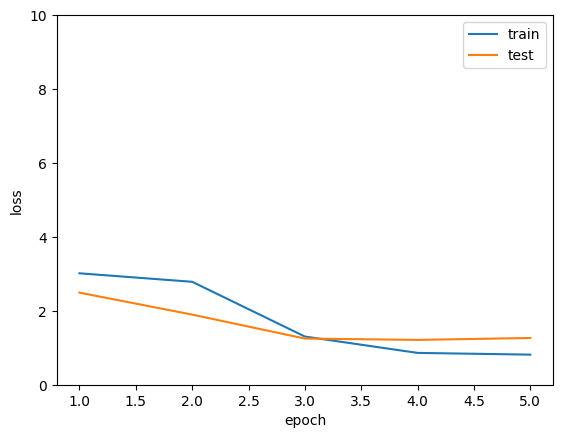

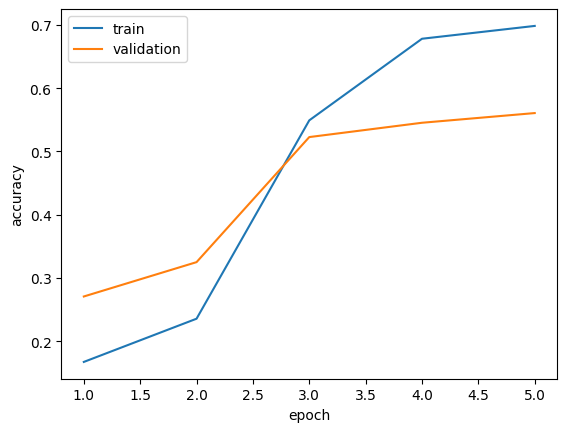

In [62]:
model = run_pipeline(X, y, model=models.resnet18(pretrained=True),
             epochs=5, batch_size=1024, transform=None, test_step=1, lr=3e-3, weight_decay=0)

In [ ]:
# nn.

# Some thoughts about project improvements.

Inception model is not used because raw image size is too small for that model (MaxPool2d layers reduce our image size too much).<br>
Considered models have their own traits & features, but for our task their behaviour tends to be almost the same. <br><br>
In out dataset we've got a class imbalance:<br>
7215 images for emotion "happy" (class 3)<br>
436 images for emotion "disgust" (class 1)<br>
~3000-5000 for other emotions
<br><br>
To overcome imbalance we used oversampling via WeightedRandomSampler, taking images with probability inversely proportional to its class amount.<br><br>
I tried technique of Super-Convergence which helps to train faster, giving us regularization affect. (That's why small wheight decay, and relatively large batch sizes are being used)
<br><br>
To improve accuracy, we can simply find better parameters, for instace do lr test, to find relative optimal parameter.
Also, it's worth noting that with larger pct_start i got better results (our lr-rising phase continued more, and loss diverged faster).

# Conlusions
During this project, i have got better understanding of Tensorflow, Keras (initially used it for current project and coded a simple model via it) and PyTorch (switched to PyTorch afterwards). In the process of completing study, I get acquainted with Google Colaboratory, different neural networks, aspecially with classifiers with backbone architecture such as ResNet, EfficientNet, Inception & GoggleNet. Learned terminology, built models, trained them and evaluated on test data, suggested base improvements & thoughts.